In [1]:
import os
import sys
import cortex
import numpy as np
import pandas as pd
import nibabel as nb
from PIL import Image
from cortex.rois import *
import matplotlib.pyplot as plt


# Personal imports
sys.path.append("{}/../../analysis_code/utils".format(os.getcwd()))
from settings_utils import load_settings
from surface_utils import load_surface ,make_surface_image
from pycortex_utils import load_surface_pycortex, set_pycortex_config_file, draw_cortex

In [4]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'
subject = 'sub-12'
pycortex_subject = subject

In [5]:
# Load settings
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
settings_path = os.path.join(base_dir, project_dir, "settings.yml")
prf_settings_path = os.path.join(base_dir, project_dir, "prf-analysis.yml")
settings = load_settings([settings_path, prf_settings_path])
analysis_info = settings[0]


rois_group_mmp = analysis_info['rois-group-mmp']



In [ ]:
'/Users/uriel/disks/meso_H/projects/pRF_analysis/analysis_code/atlas/mmp_group_atlas_rois_170k_hemi-R.npz'

In [8]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

In [9]:
# Load annot
labels_lh, ctab_lh, names_lh = nb.freesurfer.read_annot("/Users/uriel/Desktop/freesurfer/{}/label/lh.HCPMMP1.annot".format(subject))
labels_rh, ctab_rh, names_rh = nb.freesurfer.read_annot("/Users/uriel/Desktop/freesurfer/{}/label/rh.HCPMMP1.annot".format(subject))



In [10]:
img_lh, roi_lh = load_surface('/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/{}/fsnative/rois/{}_hemi-L_rois.func.gii'.format(subject, subject))
img_rh, roi_rh = load_surface('/Users/uriel/disks/meso_shared/RetinoMaps/derivatives/pp_data/{}/fsnative/rois/{}_hemi-R_rois.func.gii'.format(subject, subject))


In [11]:
roi_rh.shape[1]+roi_lh.shape[1]

285569

In [12]:
labels_lh = labels_lh.reshape(1, -1)
labels_rh = labels_rh.reshape(1, -1)

fs_mmp_img_lh = make_surface_image(data=labels_lh, source_img=img_lh)
fs_mmp_img_rh = make_surface_image(data=labels_rh, source_img=img_rh)


nb.save(fs_mmp_img_lh,'/Users/uriel/Downloads/{}_mmp_fs_hemi-L.func.gii'.format(subject)) 
nb.save(fs_mmp_img_rh,'/Users/uriel/Downloads/{}_mmp_fs_hemi-R.func.gii'.format(subject)) 

In [13]:
# mapping index -> nom (correct)
id_to_name_lh = {i: names_lh[i].decode() for i in range(len(names_lh))}
id_to_name_rh = {i: names_rh[i].decode() for i in range(len(names_rh))}

# dictionnaires ROI -> mask
roi_masks_lh = {}
roi_masks_rh = {}

for label_id, roi_name in id_to_name_lh.items():
    if roi_name == "???":
        continue

    # retire le préfixe L_ (seulement s'il est au début)
    if roi_name.startswith("L_"):
        roi_clean = roi_name[len("L_"):]
    else:
        roi_clean = roi_name

    # retire le suffixe _ROI (seulement s'il est à la fin)
    if roi_clean.endswith("_ROI"):
        roi_clean = roi_clean[:-len("_ROI")]

    roi_masks_lh[roi_clean] = (labels_lh == label_id)
    roi_masks_lh[roi_clean] = roi_masks_lh[roi_clean].squeeze()


for label_id, roi_name in id_to_name_rh.items():
    if roi_name == "???":
        continue

    if roi_name.startswith("R_"):
        roi_clean = roi_name[len("R_"):]
    else:
        roi_clean = roi_name

    if roi_clean.endswith("_ROI"):
        roi_clean = roi_clean[:-len("_ROI")]

    roi_masks_rh[roi_clean] = (labels_rh == label_id)
    roi_masks_rh[roi_clean] = roi_masks_rh[roi_clean].squeeze()

In [14]:
a = roi_masks_rh['V1'].squeeze()

In [15]:
roi_masks_rh['V1']

array([ True,  True,  True, ..., False, False, False], shape=(141841,))

In [16]:
roi_masks = {}

for key in roi_masks_lh.keys():
    roi_masks[key] = np.concatenate([roi_masks_lh[key], roi_masks_rh[key]],axis=0).squeeze()

In [31]:
roi_masks['V1'].shape

(285569,)

In [10]:
roi_list = [
 "V1",
 "V2",
 "V3", "V4",
 "V3A", "V3B", "V3CD",
 "LO1", "LO2", "LO3",
 "V8", "PIT", "PH", "FFC", "VMV1", "VMV2", "VMV3", "VVC",
 "V4t", "MST", "MT", "FST",
 "IP0", "IPS1", "V7", "MIP", "IP1", "V6A", "7PL",
 "VIP", "LIPv", "LIPd", "IP2", "7PC", "AIP", "7AL", "7Am", "7Pm",
 "PEF", "IFJp", "6v", "6r", "IFJa", "55b",
 "FEF", "i6-8", "6a", "6d", "6mp", "6ma",
 "SCEF", "p32pr", "24dv"
]

# Initialiser un masque vide (False)
mask_lh = np.zeros_like(labels_lh, dtype=bool)
mask_rh = np.zeros_like(labels_rh, dtype=bool)

# Remplir les masques
for roi in roi_list:
    roi_mask_lh = roi_masks_lh.get(roi)
    roi_mask_rh = roi_masks_rh.get(roi)

    if roi_mask_lh is None or roi_mask_rh is None:
        raise KeyError(f"ROI {roi} non trouvée dans LH ou RH")

    mask_lh |= roi_mask_lh
    mask_rh |= roi_mask_rh

# Concat LH + RH
roi_mask = np.concatenate([mask_lh, mask_rh], axis=1)

# Convertir en 0/1
mask_int = roi_mask.astype(int)

In [12]:
roi_masks['V1'].shape

(285569,)

In [13]:
mask_rh.shape

(1, 141841)

# Plot

In [ ]:
# mmp_colormap_fn = '{}/db/sub-170k/Glasser2016_ColorLUT.txt'.format(cortex_dir)
# # creating an MMP colormap as png
# np_cmap = pd.read_csv(mmp_colormap_fn, delimiter='\t')[[' R ',' G ',' B ', ' A ']].astype(np.uint8)
# np_cmap[' A '] = np.ones(np_cmap.shape[0], dtype=np.uint8) * 255
# png = np.zeros((1,256,4), dtype=np.uint8)
# png[0,:np.array(np_cmap).shape[0],:] = np.array(np_cmap)
# im = Image.fromarray(png, 'RGBA')
# im.save('{}/colormaps/HCP_MMP1.png'.format(cortex_dir))
# plt.matshow(png)
# plt.axis('off')

In [45]:
results = load_surface_pycortex(L_fn='/Users/uriel/Downloads/{}_mmp_fs_hemi-L.func.gii'.format(subject), 
                                R_fn='/Users/uriel/Downloads/{}_mmp_fs_hemi-R.func.gii'.format(subject))
deriv_mat = results['data_concat']

In [47]:
pycortex_subject = subject
colormap_name = 'HCP_MMP1'

In [16]:
alpha_mat = np.ones(deriv_mat.shape)


In [57]:
V1_mask_brain = np.concatenate([roi_group_masks_lh['VO'], roi_group_masks_rh['VO']], axis=0)
a = V1_mask_brain.astype(int).reshape(1,-1)

In [58]:
pycortex_subject

'sub-12'

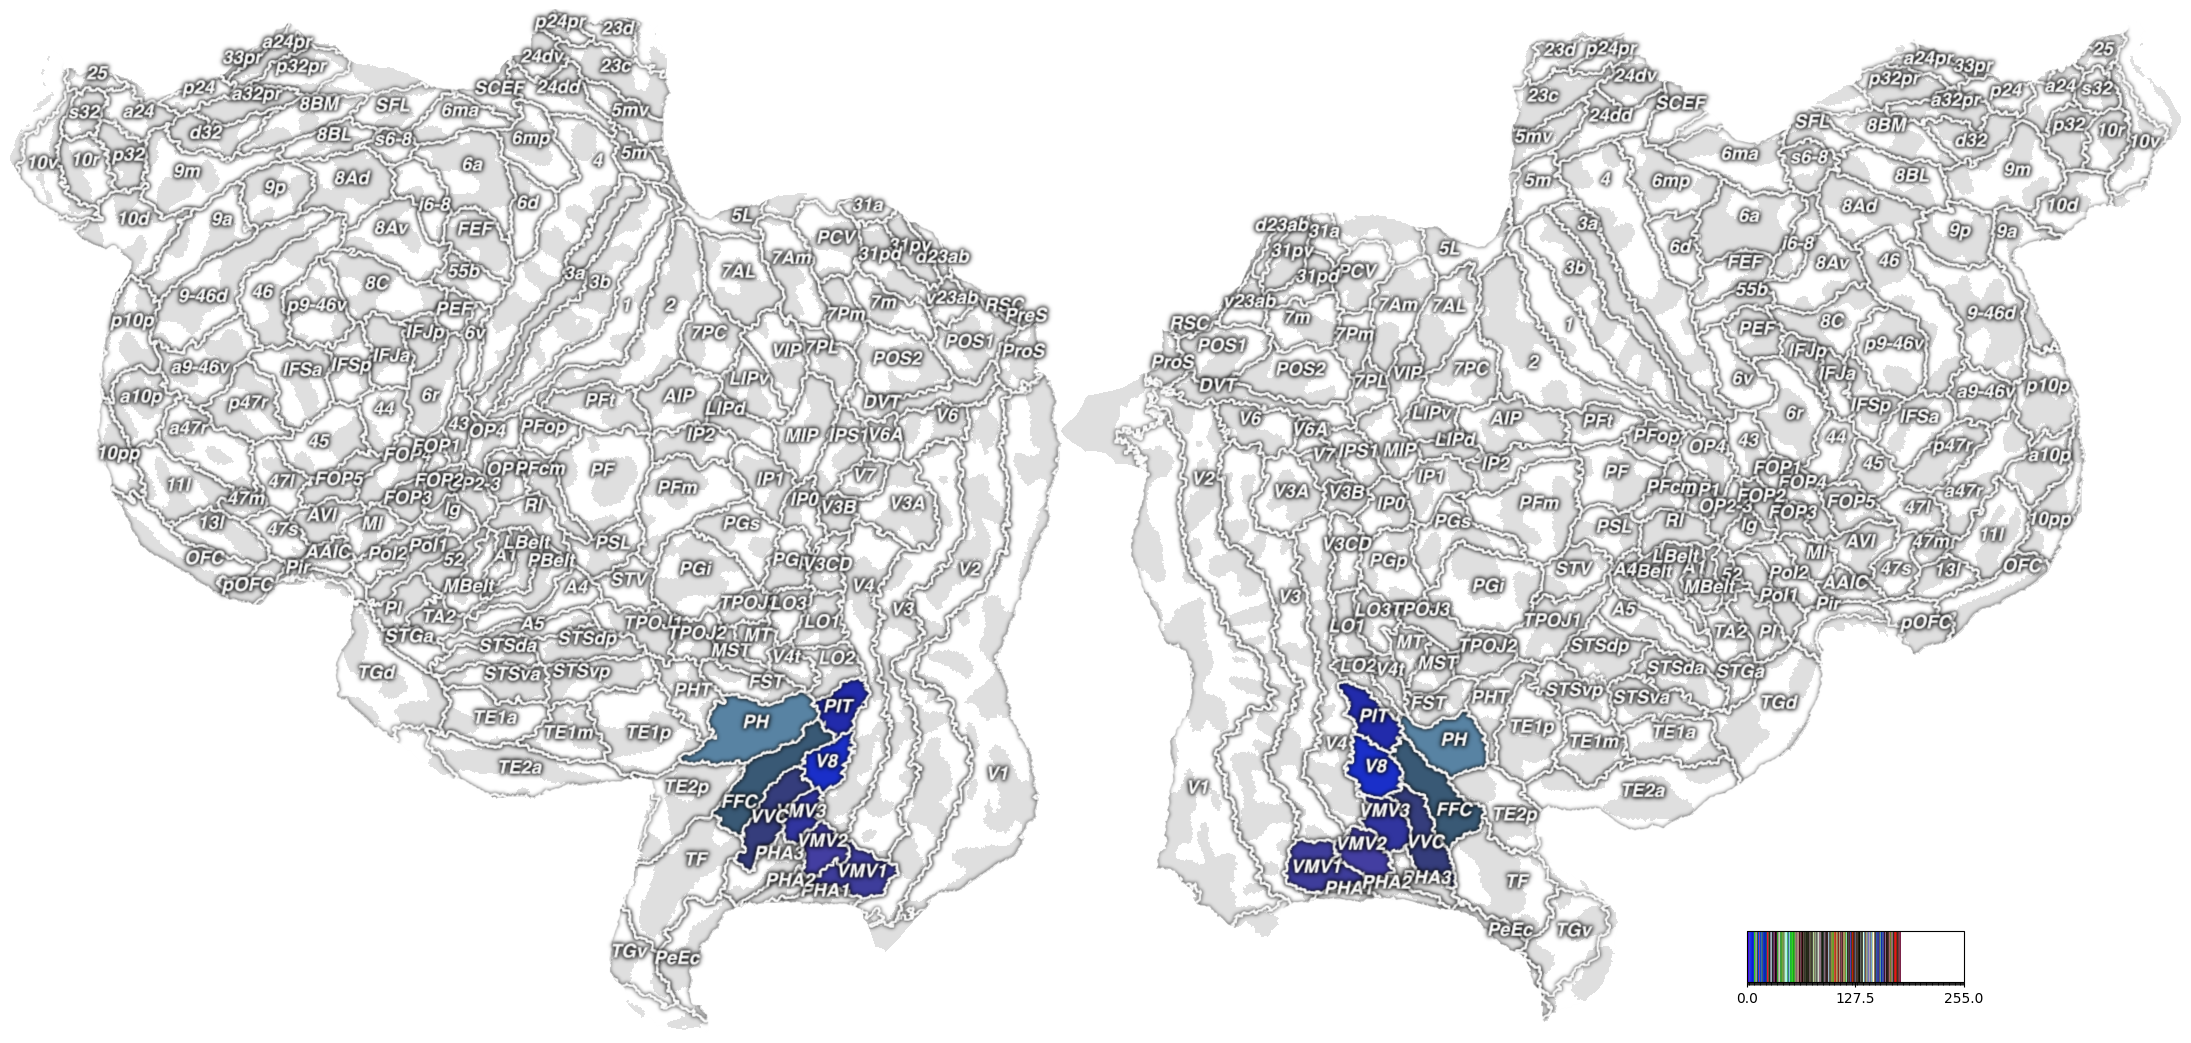

In [59]:
# Pycortex settings
roi_name = 'mmp_fsnayive'
param_rois = {'subject': pycortex_subject,
              'data': deriv_mat, 
              'cmap': colormap_name,
              'alpha': a,
              # 'alpha': deriv_mat,
              'cbar': 'discrete', 
              'vmin': 0,
              'vmax': 255,
              'cmap_steps': 255,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

# Plot
volume_roi = draw_cortex(**param_rois)
# plt.savefig('/Users/uriel/Downloads/mmp_atlas.pdf')

In [19]:
# pycortex_subject = 'sub-01'
# colormap_name = 'HCP_MMP1'
# # plot mmp 
# vertex_data = cortex.Vertex(deriv_mat, pycortex_subject, cmap=colormap_name)

# cortex.quickshow(vertex_data, with_colorbar=False)
# plt.title("MMP atlas", fontsize=25)

# plt.show()

# Export npz and make border on overlay

In [21]:
rois_npz_fn = '/Users/uriel/Downloads/{}_mmp_atlas_rois.npz'.format(pycortex_subject)
np.savez(rois_npz_fn, **roi_masks)

In [22]:
overlay_fn ='/Users/uriel/Desktop/overlays.svg'
rp = ROIpack(pycortex_subject, rois_npz_fn)
rp.to_svg(filename=overlay_fn)

Adding V1
Adding MST


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V6
Adding V2


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V3
Adding V4


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V8
Adding 4


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 3b
Adding FEF


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PEF
Adding 55b


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V3A
Adding RSC


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding POS2
Adding V7


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding IPS1
Adding FFC


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V3B
Adding LO1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding LO2
Adding PIT


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding MT
Adding A1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PSL
Adding SFL


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PCV
Adding STV


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 7Pm
Adding 7m


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding POS1
Adding 23d


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding v23ab
Adding d23ab


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 31pv
Adding 5m


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 5mv
Adding 23c


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 5L
Adding 24dd


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 24dv
Adding 7AL


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding SCEF
Adding 6ma


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 7Am
Adding 7PL


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 7PC
Adding LIPv


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding VIP
Adding MIP


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 1
Adding 2


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 3a
Adding 6d


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 6mp
Adding 6v


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding p24pr
Adding 33pr


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding a24pr
Adding p32pr


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding a24
Adding d32


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 8BM
Adding p32


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 10r
Adding 47m


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 8Av
Adding 8Ad


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 9m
Adding 8BL


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 9p
Adding 10d


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 8C
Adding 44


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 45
Adding 47l


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding a47r
Adding 6r


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding IFJa
Adding IFJp


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding IFSp
Adding IFSa


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding p9-46v
Adding 46


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding a9-46v
Adding 9-46d


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 9a
Adding 10v


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding a10p
Adding 10pp


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 11l
Adding 13l


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding OFC
Adding 47s


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding LIPd
Adding 6a


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding i6-8
Adding s6-8


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 43
Adding OP4


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding OP1
Adding OP2-3


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 52
Adding RI


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PFcm
Adding PoI2


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding TA2
Adding FOP4


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding MI
Adding Pir


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding AVI
Adding AAIC


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding FOP1
Adding FOP3


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding FOP2
Adding PFt


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding AIP
Adding EC
Adding PreS
Adding H
Adding ProS


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PeEc
Adding STGa


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PBelt
Adding A5


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PHA1
Adding PHA3


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding STSda
Adding STSdp


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding STSvp
Adding TGd


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding TE1a
Adding TE1p


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))


Adding TE2a
Adding TF


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding TE2p
Adding PHT


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PH
Adding TPOJ1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding TPOJ2
Adding TPOJ3


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding DVT
Adding PGp


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding IP2
Adding IP1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding IP0
Adding PFop


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PF
Adding PFm


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PGi
Adding PGs


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V6A
Adding VMV1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding VMV3
Adding PHA2


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V4t
Adding FST


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding V3CD
Adding LO3


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding VMV2
Adding 31pd


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 31a
Adding VVC


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding 25
Adding s32


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding pOFC
Adding PoI1


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding Ig
Adding FOP5


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding p10p
Adding p47r


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding TGv
Adding MBelt


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding LBelt
Adding A4


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding STSva
Adding TE1m


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding PI
Adding a32pr


/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.closing` instead.
  img = binary_closing(img, disk(2))
/Users/uriel/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py:88: FutureWarning: `binary_closing` is deprecated since version 0.26 and will be 

Adding p24


In [ ]:
~/softwares/anaconda3/envs/nCSF_env/lib/python3.11/site-packages/cortex/rois.py

In [ ]:
roi_masks['V1']

In [ ]:
pd.DataFrame(a.astype(int)).to_csv(
    '/Users/uriel/Downloads/a.csv',
    sep='\t',
    na_rep='NaN',
    index=False,
    header=False
)

In [3]:
rois_dict_59k = dict(np.load('/Users/uriel/disks/meso_H/projects/RetinoMaps/analysis_code/atlas/mmp_atlas_rois_59k_hemi-R.npz'))

In [6]:
rois_dict_59k['V1'].shape

(59292,)

In [17]:
roi_group_masks_lh = {}
roi_group_masks_rh = {}

for group_name, roi_list in rois_group_mmp.items():
    masks_lh = [roi_masks_lh[roi] for roi in roi_list if roi in roi_masks_lh]
    masks_rh = [roi_masks_rh[roi] for roi in roi_list if roi in roi_masks_rh]

    if len(masks_lh) > 0:
        roi_group_masks_lh[group_name] = np.logical_or.reduce(masks_lh)

    if len(masks_rh) > 0:
        roi_group_masks_rh[group_name] = np.logical_or.reduce(masks_rh)
        

In [18]:
roi_group_masks_rh

{'V1': array([ True,  True,  True, ..., False, False, False], shape=(141841,)),
 'V2': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'V3': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'V3AB': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'LO': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'VO': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'hMT+': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'iIPS': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'sIPS': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'iPCS': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'sPCS': array([False, False, False, ..., False, False, False], shape=(141841,)),
 'mPCS': array([False, False, False, ..., False, False, False], shape=(141841,))}

In [54]:
V1_mask_brain = np.concatenate([roi_group_masks_lh['V1'], roi_group_masks_rh['V1']], axis=0)

In [41]:
roi_masks_lh

{'V1': array([ True,  True,  True, ..., False, False, False], shape=(143728,)),
 'MST': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V6': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V2': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V3': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V4': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V8': array([False, False, False, ..., False, False, False], shape=(143728,)),
 '4': array([False, False, False, ..., False, False, False], shape=(143728,)),
 '3b': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'FEF': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'PEF': array([False, False, False, ..., False, False, False], shape=(143728,)),
 '55b': array([False, False, False, ..., False, False, False], shape=(143728,)),
 'V3A': array([False, False, False, .